In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

import spacy
import nltk
import nltk.data
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import regex as re
import string
from collections import defaultdict

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
#from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV

from gensim.models import FastText
from gensim.models.keyedvectors import KeyedVectors

import itertools

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TP1-AntiDiscriminator/datasets/final/hsd_merge_cleaned_lowered.csv')
df.head()

In [ ]:
#df.drop(columns = ['Unnamed: 0', 'acctdesc' ,'location', 'following', 'followers', 'totaltweets', 'usercreatedts', 'tweetcreatedts', 'retweetcount', 'hashtags', ], inplace = True)
df.head(5)

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 42)

print(f'Training set shape: {df_train.shape}')
print(f'Test set shape: {df_test.shape}')

In [ ]:
punctuations = "¡!#$%&'()*+,-./:;<=>¿?@[\]^_`{|}~"

def read_txt(filename):
    list = []
    with open(filename, 'r', encoding='utf-8') as f:
        data = f.readlines()
        for line in data:
            list.append(str(line).replace('\n', ''))
    return list

stopwords = read_txt('/content/drive/MyDrive/TP1-AntiDiscriminator/Codigo/Benitez/spanish_stopwords.txt')

stemmer = SnowballStemmer('spanish')

In [ ]:
def clean_accents(tweet):
    tweet = re.sub(r"[àáâãäå]", "a", tweet)
    tweet = re.sub(r"ç", "c", tweet)
    tweet = re.sub(r"[èéêë]", "e", tweet)
    tweet = re.sub(r"[ìíîï]", "i", tweet)
    tweet = re.sub(r"[òóôõö]", "o", tweet)
    tweet = re.sub(r"[ùúûü]", "u", tweet)
    tweet = re.sub(r"[ýÿ]", "y", tweet)

    return tweet

def clean_tweet(tweet, stem = False):
    tweet = tweet.lower().strip()
    tweet = re.sub(r'https?:\/\/\S+', '', tweet)
    tweet = re.sub(r'http?:\/\/\S+', '', tweet)
    tweet = re.sub(r'www?:\/\/\S+', '', tweet)
    tweet = re.sub(r'\s([@#][\w_-]+)', "", tweet)
    tweet = re.sub(r"\n", " ", tweet)
    tweet = clean_accents(tweet)
    tweet = re.sub(r"\b(a*ha+h[ha]*|o?l+o+l+[ol]*|x+d+[x*d*]*|a*ja+[j+a+]+)\b", "<risas>", tweet)
    for symbol in punctuations:
        tweet = tweet.replace(symbol, "")
    tokens = []
    for token in tweet.strip().split():
        if token not in punctuations and token not in stopwords:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
df['text_cleaned'] = df['text'].apply(lambda s : clean_tweet(s))
df_train['text_cleaned'] = df_train['text'].apply(lambda s : clean_tweet(s))
df_test['text_cleaned'] = df_test['text'].apply(lambda s : clean_tweet(s))

print(df_train['text_cleaned'].head(5))

In [ ]:
df_train.drop_duplicates(subset=['text_cleaned'], keep='last', inplace = True)
df_test.drop_duplicates(subset=['text_cleaned'], keep='last', inplace = True)

In [ ]:
#fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=200)
#plt.tight_layout()
#
#target_count = df_train.groupby('target').count()['username']
#not_racist_pct = round(target_count[0]/(target_count[0] + target_count[1]),3)
#racist_pct = 1 - not_racist_pct
#
#target_count.plot(kind='pie', ax=axes[0], labels=[f'Not racist({not_racist_pct*100}%)', f'Racist({racist_pct*100}%)'])
#sns.countplot(x=df['target'], hue=df['target'], ax=axes[1])
#
#axes[0].set_ylabel('')
#axes[1].set_ylabel('')
#axes[1].set_xticklabels([f'Not racist ({target_count[0]})', f'Racist ({target_count[1]})'])
#axes[0].tick_params(axis='x', labelsize=15)
#axes[0].tick_params(axis='y', labelsize=15)
#axes[1].tick_params(axis='x', labelsize=15)
#axes[1].tick_params(axis='y', labelsize=15)
#
#axes[0].set_title('Target Distribution in Training Set', fontsize=13)
#axes[1].set_title('Target Count in Training Set', fontsize=13)
#
#plt.show()

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text_cleaned)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

In [ ]:
MAX_SEQUENCE_LENGTH = 50
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text_cleaned),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text_cleaned),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)
print(x_train[0])

In [ ]:
y_train = pd.DataFrame(df_train['label'])
y_test = pd.DataFrame(df_test['label'])

print("Training y Shape:", y_train.shape)
print("Testing y Shape:", y_test.shape)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def to_df(x, y):
    d = {"text": x, "label": y}
    return pd.DataFrame(d)

def split_3(df, test_size=0.2, valid_size=0.2):
    _df = df.copy().sample(frac=1).reset_index()
    _df = _df[["text", "label"]]

    x = df["text"].copy()
    y = df["label"].copy()
    #split train-test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, stratify=y)
    # split train-valid
    x, y = x_train, y_train
    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=valid_size, stratify=y)
    return to_df(x_train, y_train), to_df(x_valid, y_valid), to_df(x_test, y_test)

In [ ]:
import numpy as np
import pandas as pd

tname_data = "/content/drive/MyDrive/TP1-AntiDiscriminator/datasets/final/hsd_merge_cleaned_lowered"
data = pd.read_csv(f"{tname_data}.csv")

train, valid, test = split_3(data)

X_train = train['text']
y_train = train['label']

X_valid = valid['text']
y_valid = valid['label']

X_test = test['text']
y_test = test['label']

In [ ]:
#Nuestro
import pandas as pd
from glob import glob

train_sentences = list(train['text'].values)
train_labels = list(train['label'].values)

valid_sentences = list(valid['text'].values)
valid_labels = list(valid['label'].values)

test_sentences = list(test['text'].values)
test_labels = list(test['label'].values)

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install transformers -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.5 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

In [ ]:
tokenizer.vocab_size

31002

In [ ]:
#choose max_length for beto model based on the input length

max_length = 0
list_len=[]
for sentence in train_sentences:
    length = len(tokenizer.tokenize(sentence))
    list_len.append(length)

from collections import Counter
Counter(list_len).most_common(100)

[(17, 357),
 (21, 342),
 (15, 338),
 (18, 324),
 (16, 319),
 (19, 316),
 (12, 315),
 (22, 311),
 (24, 310),
 (14, 308),
 (20, 305),
 (13, 303),
 (23, 301),
 (10, 296),
 (26, 289),
 (9, 274),
 (25, 273),
 (11, 264),
 (27, 262),
 (29, 246),
 (28, 230),
 (8, 197),
 (30, 190),
 (31, 179),
 (7, 171),
 (33, 164),
 (32, 156),
 (6, 148),
 (34, 131),
 (5, 111),
 (35, 108),
 (36, 106),
 (39, 100),
 (43, 93),
 (40, 92),
 (53, 90),
 (49, 90),
 (47, 90),
 (50, 88),
 (41, 86),
 (44, 86),
 (38, 86),
 (37, 84),
 (54, 84),
 (51, 81),
 (42, 78),
 (46, 76),
 (52, 76),
 (57, 71),
 (45, 66),
 (48, 66),
 (56, 64),
 (58, 63),
 (4, 60),
 (55, 57),
 (59, 48),
 (60, 41),
 (61, 40),
 (64, 38),
 (62, 31),
 (66, 24),
 (65, 23),
 (3, 22),
 (63, 20),
 (67, 17),
 (2, 13),
 (68, 8),
 (69, 7),
 (70, 4),
 (71, 4),
 (74, 4),
 (72, 4),
 (1, 4),
 (81, 2),
 (75, 2),
 (80, 2),
 (73, 1),
 (78, 1),
 (76, 1),
 (87, 1)]

In [ ]:
#Nuestro
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(train_labels)
encoded_train_labels = le.transform(train_labels)
encoded_valid_labels = le.transform(valid_labels)
encoded_test_labels = le.transform(test_labels)

In [ ]:
#Nuestro
# Tokens IDs tensor
import torch

def encoder_generator(sentences,labels):

    sent_index = []
    input_ids = []
    attention_masks =[]

    for index,sent in enumerate(sentences):

        sent_index.append(index)

        encoded_dict = tokenizer.encode_plus(sent,
                                             add_special_tokens=True,
                                             max_length=50,
                                             padding='max_length',
                                             truncation = True,
                                             return_attention_mask=True,
                                             return_tensors='pt')
        input_ids.append(encoded_dict['input_ids'])

        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids,dim=0).cuda()
    attention_masks = torch.cat(attention_masks,dim=0).cuda()
    labels = torch.tensor(labels).cuda()
    sent_index = torch.tensor(sent_index).cuda()

    return sent_index,input_ids,attention_masks,labels

train_sent_index,train_input_ids,train_attention_masks,train_encoded_label_tensors = encoder_generator(train_sentences,encoded_train_labels)
valid_sent_index,valid_input_ids,valid_attention_masks,valid_encoded_label_tensors = encoder_generator(valid_sentences,encoded_valid_labels)
print('Original: ', train_sentences[0])
print('Token IDs:', train_input_ids[0])

Original:  muy ignorante la sra red a las afp cierto a la sra que habla de delincuencia
Token IDs: tensor([    4,  1456,  8180,  1277,  1030, 21266, 30932,  4272,  1013,  1089,
         2359, 30944,  3015,  1013,  1030, 21266, 30932,  1038,  4124,  1008,
        13319,     5,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
       device='cuda:0')


In [ ]:
GLOVE_EMB = '../data/embeddings/embeddings-l-model.vec'
EMBEDDING_DIM = 768
LR = 5e-4
BATCH_SIZE = 100
EPOCHS = 50

In [ ]:
cantidad = 1313423
#wordvectors = KeyedVectors.load_word2vec_format(GLOVE_EMB, limit=cantidad)

In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = wordvectors[word]
        embedding_matrix[i] = embedding_vector
    except:
        pass

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(f'Embeddings coverage: {round(nonzero_elements / vocab_size,4)*100}')

Embeddings coverage: 0.0


In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = LSTM(64)(embedding_sequences)
x = Dense(256,name='FC1')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 768)           23592960  
                                                                 
 lstm_2 (LSTM)               (None, 64)                213248    
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 dense_6 (Dense)             (None, 512)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               2626

In [ ]:
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [ ]:

np_tensor = train_input_ids.cpu().numpy()
train_input_ids = tf.convert_to_tensor(np_tensor)

Instructions for updating:
Use tf.identity with explicit device placement instead.


In [ ]:
type(train_input_ids)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
np_tensor = train_encoded_label_tensors.cpu().numpy()
train_encoded_label_tensors = tf.convert_to_tensor(np_tensor)

In [ ]:
type(train_encoded_label_tensors)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
np_tensor = valid_input_ids.cpu().numpy()
valid_input_ids = tf.convert_to_tensor(np_tensor)

In [ ]:
np_tensor = valid_encoded_label_tensors.cpu().numpy()
valid_encoded_label_tensors = tf.convert_to_tensor(np_tensor)

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
history = model.fit(train_input_ids, train_encoded_label_tensors, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(valid_input_ids, valid_encoded_label_tensors), callbacks=[ReduceLROnPlateau])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


102/102 [==============================] - 8s 78ms/step - loss: 0.6844 - accuracy: 0.8610 - val_loss: 0.6754 - val_accuracy: 0.8611 - lr: 5.0000e-04
Epoch 2/50
102/102 [==============================] - 11s 103ms/step - loss: 0.6670 - accuracy: 0.8610 - val_loss: 0.6585 - val_accuracy: 0.8611 - lr: 5.0000e-04
Epoch 3/50
102/102 [==============================] - 7s 67ms/step - loss: 0.6505 - accuracy: 0.8610 - val_loss: 0.6424 - val_accuracy: 0.8611 - lr: 5.0000e-04
Epoch 4/50
102/102 [==============================] - 8s 80ms/step - loss: 0.6348 - accuracy: 0.8610 - val_loss: 0.6271 - val_accuracy: 0.8611 - lr: 5.0000e-04
Epoch 5/50
102/102 [==============================] - 8s 75ms/step - loss: 0.6200 - accuracy: 0.8610 - val_loss: 0.6127 - val_accuracy: 0.8611 - lr: 5.0000e-04
Epoch 6/50
102/102 [==============================] - 10s 96ms/step - loss: 0.6060 - accuracy: 0.8610 - val_loss: 0.5991 - val_accuracy: 0.8611 - lr: 5.0000e-04
Epoch 7/50
102/102 [============================

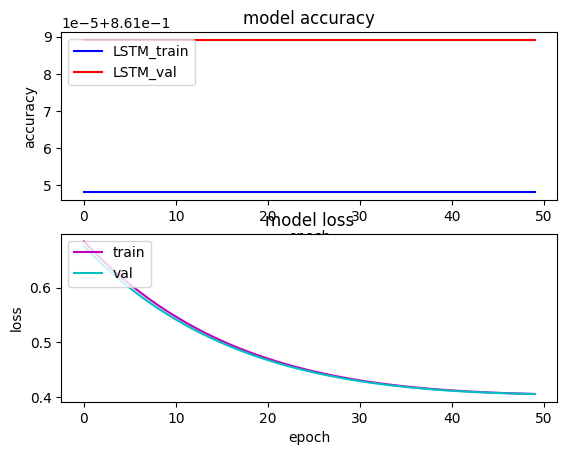

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [ ]:
test_sent_index, test_input_ids, test_attention_masks, test_encoded_label_tensors = encoder_generator(test_sentences,encoded_test_labels)

In [ ]:
np_tensor = test_encoded_label_tensors.cpu().numpy()
test_encoded_label_tensors = tf.convert_to_tensor(np_tensor)

In [ ]:
np_tensor = test_input_ids.cpu().numpy()
test_input_ids = tf.convert_to_tensor(np_tensor)

In [ ]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0


scores = model.predict(test_input_ids, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

1/1 [==============================] - 0s 87ms/step


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

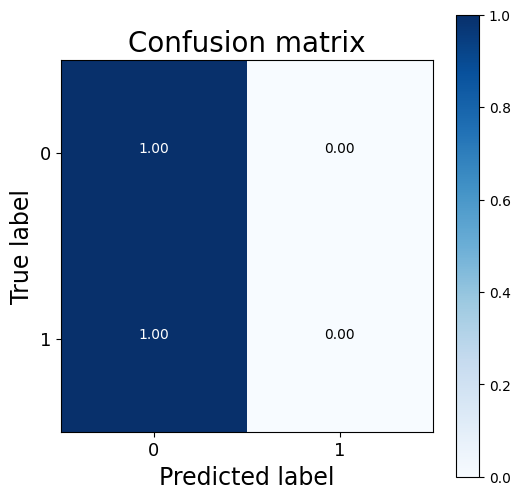

In [ ]:
cnf_matrix = confusion_matrix(test_encoded_label_tensors, y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=df_test.label.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(list(test_encoded_label_tensors), y_pred_1d,digits=4))

              precision    recall  f1-score   support

           0     0.8611    1.0000    0.9253      2727
           1     0.0000    0.0000    0.0000       440

    accuracy                         0.8611      3167
   macro avg     0.4305    0.5000    0.4627      3167
weighted avg     0.7414    0.8611    0.7968      3167



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def create_model(num_dense_units, vocab_size, embedding_dim, maxlen, lr):
    embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                              embedding_dim,
                                              weights=[embedding_matrix],
                                              input_length=maxlen,
                                              trainable=False)
    sequence_input = Input(shape=(maxlen,), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    x = LSTM(64)(embedding_sequences)
    x = Dense(256,name='FC1')(x)
    x = Dense(num_dense_units, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_dense_units, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(sequence_input, outputs)
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
param_grid = dict(num_dense_units=[32, 64, 128, 256, 512],
                  vocab_size=[vocab_size],
                  embedding_dim=[EMBEDDING_DIM],
                  maxlen=[MAX_SEQUENCE_LENGTH],
                  lr = [2e-3, 3e-3, 4e-3])

In [ ]:
model = KerasClassifier(build_fn=create_model,
                            epochs=EPOCHS, batch_size=BATCH_SIZE,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(x_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(x_test, y_test)

print(f'Best accuracy: {grid_result.best_score_}')
print(f'Params: {grid_result.best_params_}')
print(f'Test accuracy: {test_accuracy}')

<ipython-input-71-a5792fbfa6b2>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model,


ValueError: ignored